In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf

print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
path_to_file = tf.keras.utils.get_file(
    "sunspots.csv",
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv",
)

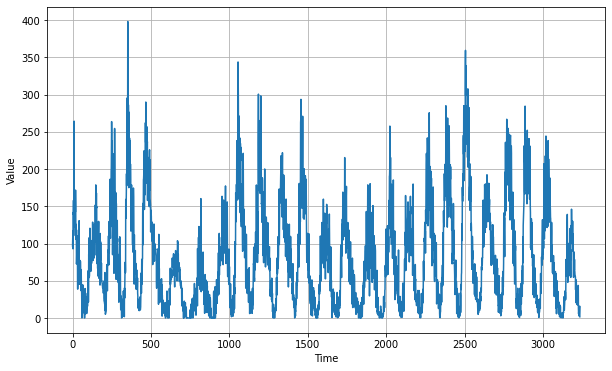

In [5]:
import csv

time_step = []
sunspots = []

with open(path_to_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    predict = model.predict(ds)
    return predict

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32,
            kernel_size=5,
            strides=1,
            padding="causal",
            activation="relu",
            input_shape=[None, 1],
        ),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="relu"),
        tf.keras.layers.Lambda(lambda x: x * 400),
    ]
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * (10 ** (epoch / 20))
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 0s 20ms/step - loss: 72.9378 - mae: 73.4271
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 72.5367 - mae: 73.0261
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 71.9176 - mae: 72.4072
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 71.1136 - mae: 71.6036
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 70.0743 - mae: 70.5644
Epoch 6/100
12/12 [==============================] - 0s 21ms/step - loss: 68.6910 - mae: 69.1810
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 66.7973 - mae: 67.2878
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 64.0352 - mae: 64.5260
Epoch 9/100
12/12 [==============================] - 0s 20ms/step - loss: 60.5725 - mae: 61.0636
Epoch 10/100
12/12 [==============================] - 0s 22ms/step - loss: 57.5833 - mae: 58.0741
Epoch 11/100
12/12 [=========

(1e-08, 0.0001, 0.0, 60.0)

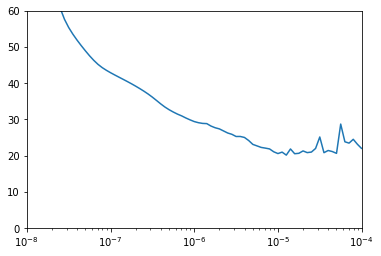

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(
    x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size
)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=60,
            kernel_size=5,
            strides=1,
            padding="causal",
            activation="relu",
            input_shape=[None, 1],
        ),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400),
    ]
)


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 11ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 10ms/step - loss: 25.7615 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 10ms/step - loss: 22.0745 - mae: 22.5682
Epoch 4/500
30/30 [==============================] - 0s 11ms/step - loss: 20.4699 - mae: 20.9628
Epoch 5/500
30/30 [==============================] - 0s 10ms/step - loss: 19.7344 - mae: 20.2269
Epoch 6/500
30/30 [==============================] - 0s 11ms/step - loss: 19.3555 - mae: 19.8475
Epoch 7/500
30/30 [==============================] - 0s 11ms/step - loss: 18.5930 - mae: 19.0849
Epoch 8/500
30/30 [==============================] - 0s 10ms/step - loss: 18.1977 - mae: 18.6894
Epoch 9/500
30/30 [==============================] - 0s 10ms/step - loss: 18.1305 - mae: 18.6221
Epoch 10/500
30/30 [==============================] - 0s 10ms/step - loss: 17.9946 - mae: 18.4857
Epoch 11/500
30/30 [=========

In [20]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size : -1, -1, 0]

ValueError: Attempt to convert a value (<TensorSliceDataset shapes: (1,), types: tf.float64>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>) to a Tensor.

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

NameError: name 'rnn_forecast' is not defined

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
# -----------------------------------------------------------
loss = history.history["loss"]

epochs = range(len(loss))  # Get number of epochs


# ------------------------------------------------
# Plot training and validation loss per epoch
# ------------------------------------------------
plt.plot(epochs, loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


zoomed_loss = loss[200:]
zoomed_epochs = range(200, 500)


# ------------------------------------------------
# Plot training and validation loss per epoch
# ------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)